# Project for the 'Programming for Data Analysys'
***

### Table of content
[1. Problem statement](#par1)<br>
[2. Define functions used for process analysis](#par2)<br>
[3. Simulate the data using``numpy.random`` package](#par3)<br>
[3.1 Simulate single variable](#par3.1)<br>
[3.1.1 Perfect process](#par3.1.1)<br>
[3.1.1 Simulate 'special causes'](#par3.1.2)<br>
[3.2 Simulate scrap ratio based on 10 dimensions](#par3.2)<br>
[4. Analise the data](#par4)<br>
<hr>

### Import all the packages

In [1]:
# import all the packackes used in the notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Create the new instance of the numpy psudorandom numbers Generator
rng = np.random.default_rng()

<a id="par1"></a>
## 1. Problem statement

- Single manufacturing process step 
- Each part has 10 measured dimenions
    - Some dimensions are correlated
- If any of the 10 dimensions is measured outside of the specified limit, part is scrapped
- Parts are manufactured in batches of 10
- Tools are changes after batch is completed

<a id="par2"></a>
## 2. Define functions used for process analysis

##### Define Histogram

In [3]:
def hist(data, label, lsl, usl, cp):
    # Calculate number of Histogram bins using Sturge’s Rule
    # as per: https://www.statisticshowto.com/choose-bin-sizes-statistics/
    bins = int(np.round(np.log10(n)*3.322+1))

    plt.hist(data, bins, density=True, label=label)

    # Draw red vertical lines for upper and lower tolerances
    plt.axvline(usl, color='r', linestyle='dashed', linewidth=1)
    plt.axvline(lsl, color='r', linestyle='dashed', linewidth=1)

    # define plot's parameters
    plt.rcParams["figure.figsize"] = [8, 4]
    plt.xlabel(' Dim1 measurement')
    plt.ylabel('Frequency of occurence')
    plt.title('Distribution of {} in a process with Cp={}'.format(label, cp))
    plt.legend()
    plt.show()

##### Define SPC chart

In [4]:
# Define a function that will check if datapoints are violating any of the SPC rules
def spc_stats(dim):
    
    # Define DataFrame with one column 'Dim'
    data = pd.DataFrame({'Dim': dim})
    
    # Add column with moving range:
    # Calculated as per https://stackoverflow.com/questions/30673209/pandas-compare-next-row
    data['mR'] = data['Dim']-data['Dim'].shift(1)
    
    # Add 'Reason' column
    data['Reason'] = 0

    # calculate the mean of the variable
    x_bar = np.mean(data['Dim'])
    mr_bar = np.mean( np.abs(data['mR'][1:len(data['mR'])]))

    # Below calculations as per 'Implementing Six Sigma' Forrest W. Breyfogle III, p227
    # Calculate Upper and Lower Control Limits for X chart 
    ucl = x_bar+mr_bar*2.66
    lcl = x_bar-mr_bar*2.66

    # Calculate Upper Control Limits for mR chart (there is no lower CL for mR chart)
    mr_ucl = mr_bar+mr_bar*3.267    
    
    # Shewhart SPC control chart rules:
    # https://analyse-it.com/docs/user-guide/process-control/shewhart-control-chart-rules
    
    # Number of observation on the same side of the mean when the alarm is switched on (typically 8 or 9)
    n_side=8
    
    # Number of consecutive points steadily increasing or decreasing to switch the alarm (typically 6)
    n_drift = 6
    
    # Number of consecutive points are alternating up and down (typically 14)
    n_alter = 8
    
    # Check for measurements aoutside the contro limits
    for index, row in data.iterrows():
        x = row[0]
        mr = row[1]
        
        if x>ucl or x<lcl:
            data.loc[index, 'Reason'] = 1
            
        if mr>mr_ucl:
            data.loc[index, 'Reason'] = 2
            
    
    # check if there ar at least 'n_side' points on the same side of the mean line
    
    # 1 if point is above x_bar, -1 if it's below
    data['xbar_side'] = np.sign(data['Dim'] - x_bar)

    # count running sum of last n_side ['xbar_side'] values
    data['sameside'] = data['xbar_side']
    for i in range(1, n_side):
        data['sameside'] =  data['sameside']  + data['xbar_side'].shift(i)
    
    data.loc[ np.abs(data['sameside'])==n_side , 'Reason'] = 3
    
    # Check for drifts in data: points are steadily increasing or decreasing
    
    data['delta_sign']=np.sign( data['mR'] )
    
    # count running sum of last n_side ['xbar_side'] values
    data['drift'] = data['delta_sign']
    for i in range(1, n_drift):
        data['drift'] =  data['drift'] + data['delta_sign'].shift(i)
    
    data.loc[ np.abs(data['drift'])==n_drift , 'Reason'] = 4
    
    # check for consecutive points are alternating up and down
    
    # column 'alter' will be 0 if 2 consecutive points alter in direction of change
    # and will be 2 if they both going up or down
    data['alter'] = np.abs(data['delta_sign'] + data['delta_sign'].shift(1) )
    
    # if there sum of the last n_alter rows of 'alter' column equal 0
    # Then that means that these points were alternating up and down for n_alter consecutive points
    data['sum_alter'] = data['alter']
    for i in range(1, n_alter):
        data['sum_alter'] =  data['sum_alter'] + data['alter'].shift(i)
    
    data.loc[ np.abs(data['sum_alter'])==0 , 'Reason'] = 5    
    
    return data[['Dim', 'mR', 'Reason']], x_bar, mr_bar, ucl, lcl, mr_ucl
    #return data, x_bar, mr_bar, ucl, lcl, mr_ucl

In [5]:
def xmr(dim):
    # Below code for SPC chart originally taken from: https://towardsdatascience.com/quality-control-charts-guide-for-python-9bb1c859c051
    
    # Find the points that are violating SPC rules and calculate the means and control limits
    data, x_bar, mr_bar, ucl, lcl, mr_ucl = spc_stats(dim)


    # Plot x and mR charts
    fig, axs = plt.subplots(2, figsize=(8,8), sharex=True)

    # X chart
    # Graph all the points 
    axs[0].plot(data['Dim'], linestyle='-', marker='o', color='black')

    
    # Add red dot when there are too many points on the same side of the mean
    axs[0].plot(data[data['Reason']==5]['Dim'], linestyle="", marker='o', color='blue')     
    
    # Add red dot when there are too many points on the same side of the mean
    axs[0].plot(data[data['Reason']==4]['Dim'], linestyle="", marker='o', color='yellow')    
    
    # Add red dot when there are too many points on the same side of the mean
    axs[0].plot(data[data['Reason']==3]['Dim'], linestyle="", marker='o', color='orange')    
    
    # Add red dot where Dim is over UCL or under LCL
    axs[0].plot(data[data['Reason']==1]['Dim'], linestyle="", marker='o', color='red')    

    # Plot blue horizontal line at the process mean
    axs[0].axhline(x_bar, color='blue')

    # Plot red dotted lines at UCL and LCL
    axs[0].axhline(ucl, color = 'red', linestyle = 'dashed')
    axs[0].axhline(lcl, color = 'red', linestyle = 'dashed')

    # Set Chart title and axis labels
    axs[0].set_title('Individual Chart')
    axs[0].set(xlabel='Part', ylabel='Measurement')


    # mR chart
    # Graph all the points 
    axs[1].plot( np.abs(data['mR']), linestyle='-', marker='o', color='black')

    # Add red dot where Dim is over UCL
    axs[1].plot(data[data['Reason']==2]['mR'], linestyle="", marker='o', color='red')

    # Plot blue horizontal line at the mR mean
    axs[1].axhline(mr_bar, color='blue')

    # Plot red dotted line at UCL
    axs[1].axhline(mr_ucl, color='red', linestyle ='dashed')

    axs[1].set_ylim(bottom=0)
    axs[1].set_title('mR Chart')
    axs[1].set(xlabel='Part', ylabel='Range')
    
    return data[data['Reason']>0]
    #return data

<a id="par3"></a>
## 3. Simulate the data using ```numpy.random``` package

<a id="par3.1"></a>
### 3.1 Simulate single variable

<a id="par3.1.1"></a>
#### 3.1.1 Perfect process

Distribution of a measurements of a single dimension in the stable manufacturing process (process that has no special causes) follows normal distribution.

##### Define Dim1 attributes

Process capability:

$$
C_{p}=\frac{USL-LSL}{6\sigma}
$$

Given the process capability and upper and lower service limits, we can calculate the underlying process standard deviation:


$$
\sigma=\frac{USL-LSL}{6 C_{p}}
$$

##### Define process parameters

In [6]:
# Nominal dimension
mu = 9.5
# Upper and Lower tollerances
lsl, usl = 9.4, 9.6
# Process capability
cp = 3
# Number of lots
nr_lots = 10
# Parts in the lot 
nr_in_lot = 10
# Total number of parts
n=nr_lots*nr_in_lot

In [7]:
# Simulate the measurements of single dimenension using normal distribution
# ccv stands for common cause variation
dim1 = pd.DataFrame({'ccv': np.random.normal(mu, (usl-lsl)/(6*cp) , n)})

##### Show distribution of dim1 using Histogram

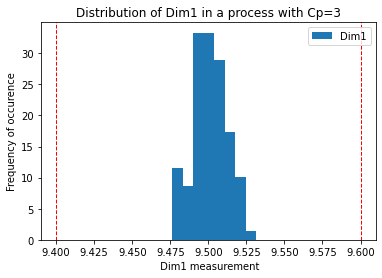

In [8]:
hist(dim1, 'Dim1', lsl, usl, cp)

##### Check Dim1 with Statistical Process Control charts

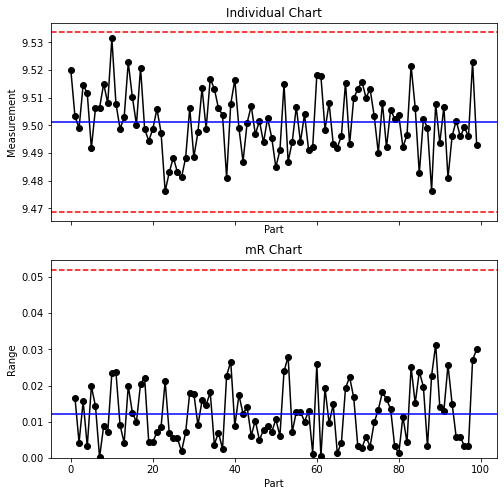

In [9]:
o = xmr(dim1.loc[:,'ccv'])

<a id="par3.1.2"></a>
#### 3.1.2 Simulate 'special causes'

##### Variation between the batches

Vatiation between the batches can be casued by:
- difrences in the fixture setup
- changes in the raw material (material hardness, forging size etc)

Distribution of batch-to-batch variation is normal.

In [10]:
lots = np.random.normal(0, 0.02 , nr_lots)
part = 0

for l in lots:
    for p in range(nr_in_lot):
       # print('part {}, batch adjustment {}'.format(part, l))
        dim1.loc[part, 'btb'] = l
        part = part + 1


# Create a 'measured' column by adding a batch-to-batch variation to the base ccv dimensions
dim1['measured'] = dim1['ccv'] + dim1['btb']

# Show data for parts in 2 first lots        
dim1.head(2*nr_in_lot)

,ccv,btb,measured
0,9.519863,0.016813,9.536676
1,9.503250,0.016813,9.520063
2,9.499035,0.016813,9.515848
3,9.514699,0.016813,9.531512
4,9.511547,0.016813,9.528359
5,9.491791,0.016813,9.508604
6,9.506126,0.016813,9.522938
7,9.506264,0.016813,9.523077
8,9.515023,0.016813,9.531836
9,9.508004,0.016813,9.524817


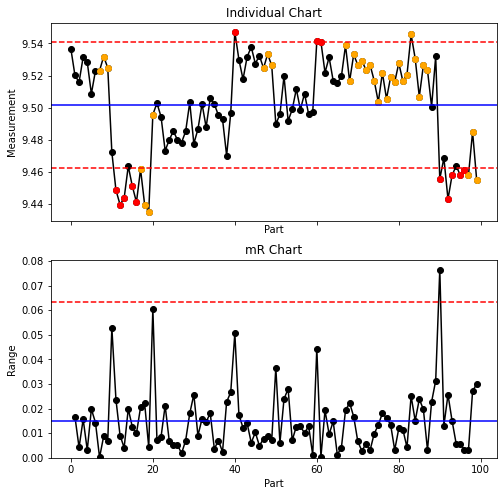

In [11]:
# Check the SPC chart for the measured dimension (common cause variation with batch-to-batch variation)
o = xmr(dim1.loc[:,'measured'])

<a id="par3.2"></a>
### 3.2 Simulate scrap ratio based on 10 dimensions

<a id="par4"></a>
## 4. Analyse the data

# End